# PART 2: UNSUPERVISED LEARNING; CLUSTERING WITH KMEANS

# Setup

In [29]:
#  importing important packages while checking versions
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
# Common imports
import numpy as np
import os
import pandas as pd
from collections import Counter

import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler as SS
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.gridspec as gspec

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


Loading Dataset and preprocessing it

In [30]:

# The Data is uploaded to Notebook in csv file, 
# we will store it in dataFrame (transactions) using pandas read_csv method
# in this Nootebook we will be analysing Test Data generated for credit card fraud.
# This Data is downloded from kaggle from this link: https://www.kaggle.com/ealaxi/paysim1

# Loading config files
import json
with open('config.json', 'r') as f:
    config = json.load(f)

# Loading datasets using pandas to variable 'transactions'
transactions = pd.read_csv(config['Training_Dataset'])

# normalize dataset
import helper
# remoing unnecessary attributes that wont be used in our clustering
transactions = helper.preprocessDataset(transactions)
#transactions_in_24hrs = transactions[transactions['step'] < 24]
transactions_in_24hrs = transactions[transactions['step'] < 24]

transactions_in_24hrs.head()


transactions.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,senderBalanceDifference,oldbalanceDest,newbalanceDest,receiverBalanceDifference,isFraud
2,1,1.0,181.00,181.0,0.0,0.00,0.0,0.00,181.0,1
3,1,0.0,181.00,181.0,0.0,0.00,21182.0,0.00,21363.0,1
15,1,0.0,229133.94,15325.0,0.0,213808.94,5083.0,51513.44,182703.5,0
19,1,1.0,215310.30,705.0,0.0,214605.30,22425.0,0.00,237735.3,0
24,1,1.0,311685.89,10835.0,0.0,300850.89,6267.0,2719172.89,-2401220.0,0


Visualizing Data distribution for each feature/attribute

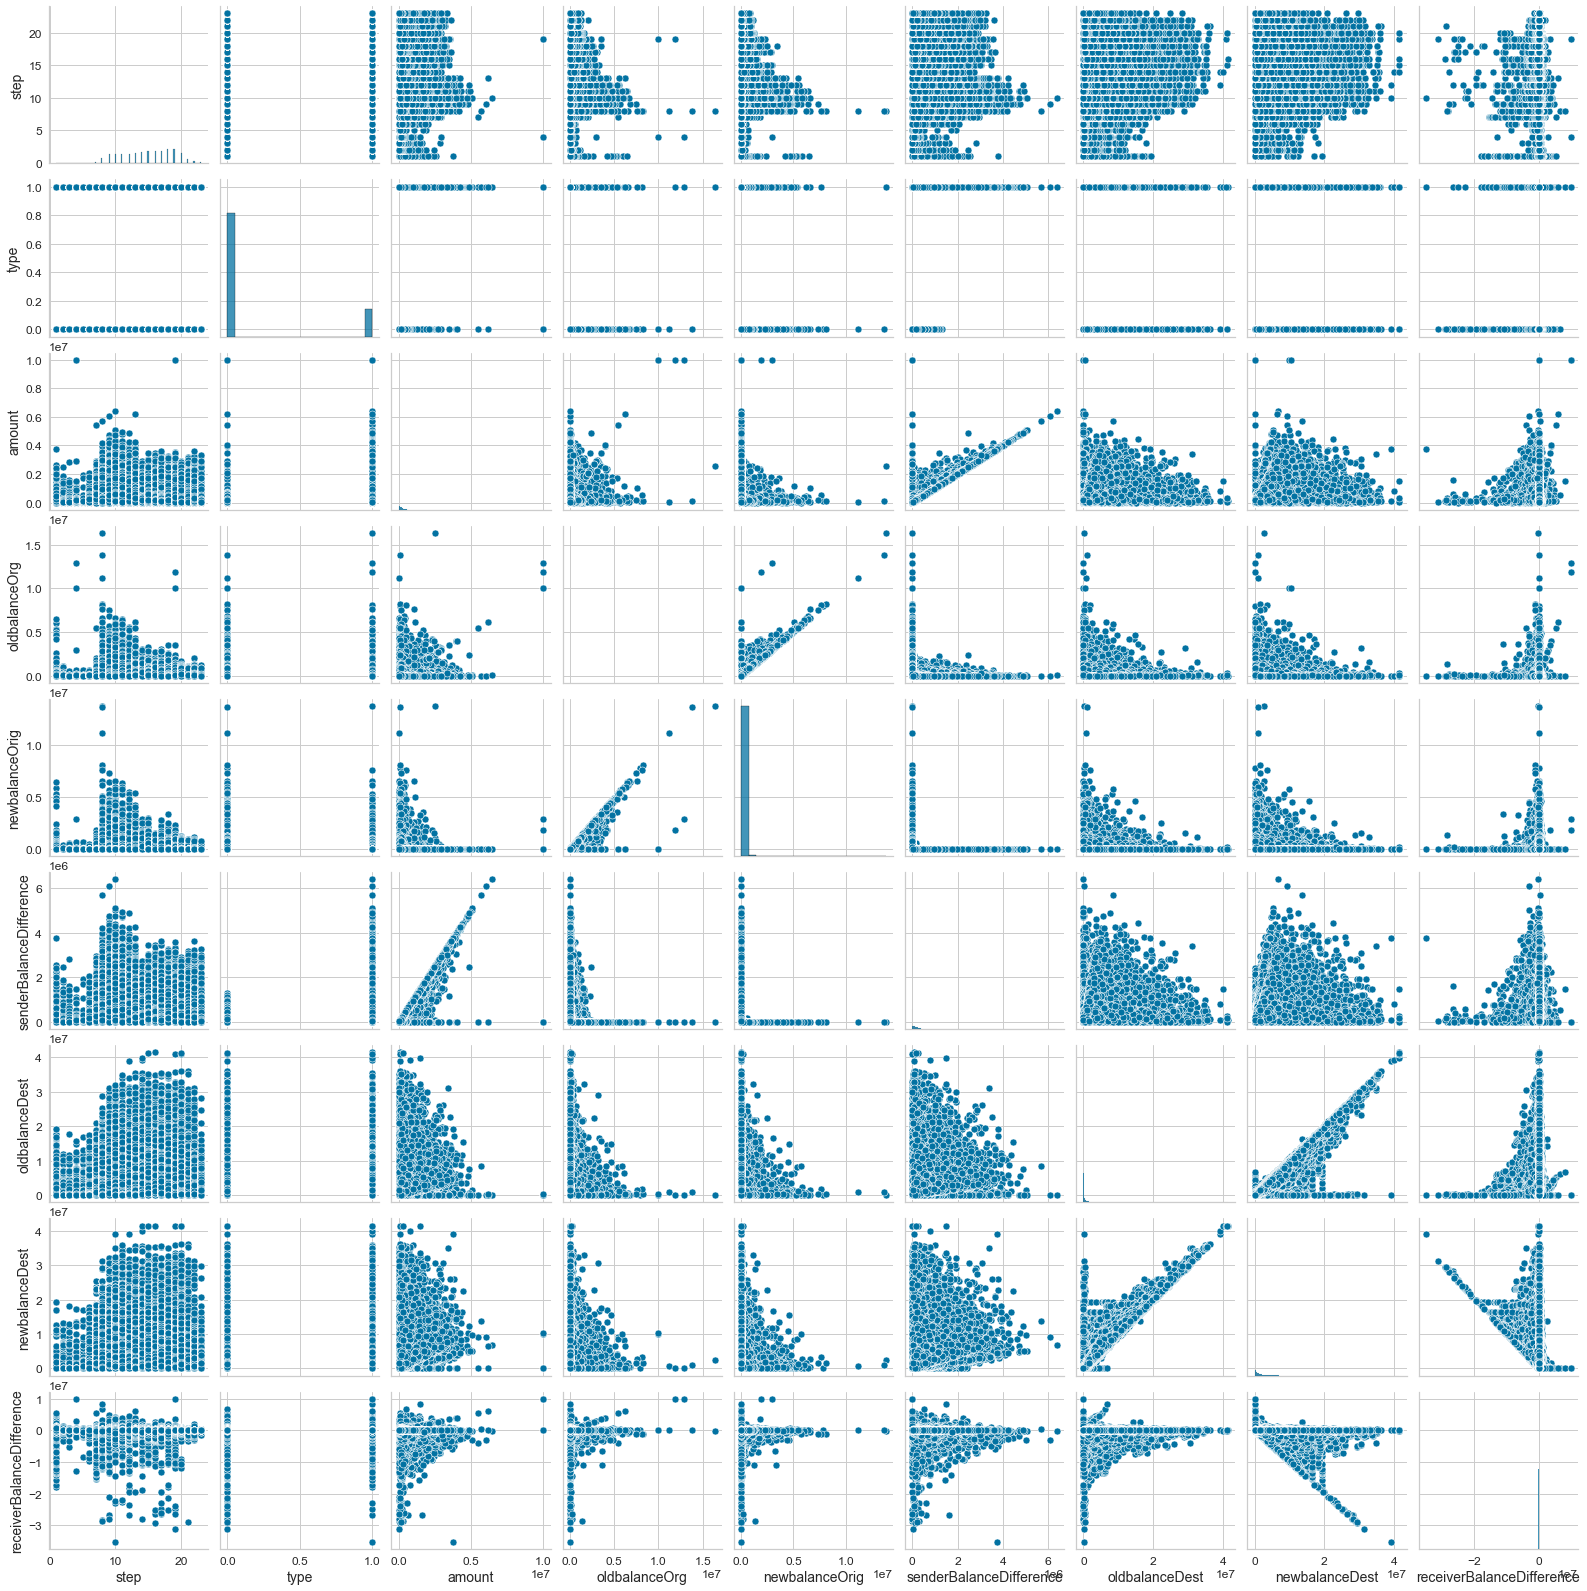

In [31]:
# Visualizing data with pairplot
X = transactions_in_24hrs.iloc[:, :-1]
y = transactions_in_24hrs['isFraud']

sns.pairplot(X)

In [35]:
X.shape

(149948, 2)

# K-MEANS Clustering

As we seen in Part 1 analysis, given data set is highly imbalanced, balancing it below before running K-Means Clustering

In [32]:
X = transactions_in_24hrs.iloc[:, :-1]
y = transactions_in_24hrs.isFraud
# balancing data
X, y = helper.balanceDataSet(X, y, 'combine')
print(X.shape)
print(Counter(y))

(149948, 9)
Counter({0: 74974, 1: 74974})


PCA Decomposition of dataset for clustering purposes

In [36]:
from sklearn.decomposition import PCA
 
#Load Data
data = X
pca = PCA(2)
 
#Transform the data
X = pca.fit_transform(data)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)



FIT and PREDIT using KMEANS Clustering

In [37]:

from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)
print(clusters)
print(kmeans.cluster_centers_)

print('SIlhoute score: ',silhouette_score(X, clusters, sample_size=10000))



[1 1 1 ... 1 1 2]
[[0.4871848  0.03240508]
 [0.28499616 0.01885626]
 [0.28266916 0.20054522]]
SIlhoute score:  0.7453489919962287


Let us visualize our clusters

In [39]:
def visulaizeCluster(centroids, lables):
    #centroids = kmeans.cluster_centers_
    u_labels = np.unique(lables)
    
    #plotting the results:
    
    for i in u_labels:
        plt.scatter(X[lables == i , 0] , X[lables == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.show()

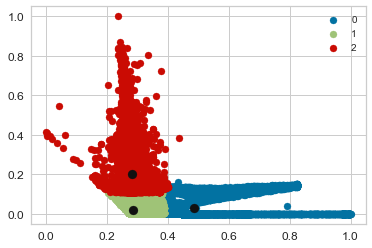

In [40]:
visulaizeCluster(kmeans.cluster_centers_, clusters)

As we have binary class K=3 seems to be doing fine for clusering with silhoute score of 0.74, let us analyse decision boundary below

DECISION BOUNTRIES
We will draw descision boundary to see how KMEANS clustering is doing

In [41]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=1, linewidths=10,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

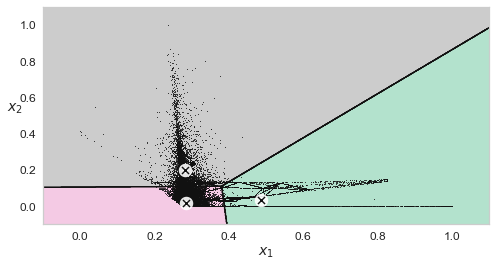

In [42]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

# TASK 2 Trying different types of clustering
On below cells i will try on running Gaussian mixture model (GMM) clustering algorithm which is soft clustering algorithm that is probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

[1 0 0 ... 0 0 1]


No handles with labels found to put in legend.


SIlhoute score:  0.4535541495776336
Accuracy for gussion Mixture Model for 2 clusters :0.367928


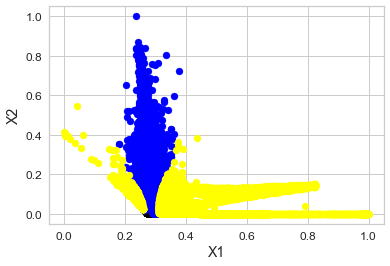

In [44]:
gaussianMixture = GaussianMixture(n_components = 3)
gaussianMixture.fit(X)

y_pred_gm = gaussianMixture.predict(X)
print(y_pred_gm)
gaussianMixture.predict_proba(X)

print('SIlhoute score: ',silhouette_score(X, y_pred_gm, sample_size=10000))
score = metrics.accuracy_score(y_pred_gm,y)
print('Accuracy for gussion Mixture Model for 2 clusters :{0:f}'.format(score))


#clusetered_data = pd.DataFrame(X,columns=['step', 'amount'])
clustered_df = pd.DataFrame(X)
clustered_df['cluster_gm'] = y_pred_gm
colours = ['black', 'blue', 'yellow', 'red', 'green', 'pink', 'brown']
for i in range(k):
    cluster = clustered_df[clustered_df.cluster_gm == i]

    plt.scatter(cluster[0], cluster[1], color=colours[i])
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='best')

Conclusion:
KMeans cluster seems to be doing better than GM, KMEANS silhoute score was about 0.74 while GM silhoute score was 0.45, even though this is unsupervised learning it seems as if though model is fitting to existing class which KMEANS is doing better than GM

# TASK 3: Trying to get Best K
I will Try Elbow method and silhoute method to best hest k for kmeans clustering

ELBOW PLOT:

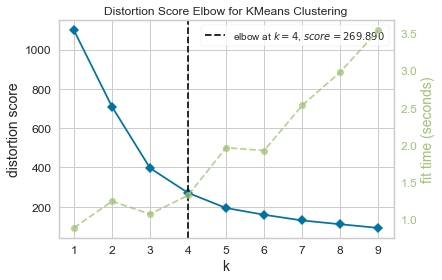

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# first step i did was getting the elbow figure to try and figure out best k for the kmeans clustering
#from sklearn.cluster import KMeans

#k_range = range(1,10)
#sse = []
#for k in k_range:
#    km = KMeans(n_clusters=k)
#    km.fit(X)
#    sse.append(km.inertia_)

#sse
#plt.xlabel('k')
#plt.ylabel('Sum Of Squered error')
#plt.plot(k_range, sse)

from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(), k=(1,10))
visualizer.fit(X)
visualizer.show()

OBSERVATIONS:

ELbow plot is showing 4 to be my best k with score 269.890, let us confirm it from silhoute plot

SILHOUTE METHOD

plotting for cluster:  2
Accuracy:0.567937
cluster labels :  [0 0 0 ... 0 0 0]
silhouette_avg :  0.7297090887668395
For n_clusters = 2 The average silhouette_score is : 0.7297090887668395
(149948, 2)
plotting for cluster:  3
Accuracy:0.411316
cluster labels :  [1 1 1 ... 1 1 2]
silhouette_avg :  0.7498286017435354
For n_clusters = 3 The average silhouette_score is : 0.7498286017435354
(149948, 2)
plotting for cluster:  4
Accuracy:0.462787
cluster labels :  [0 0 0 ... 0 0 2]
silhouette_avg :  0.7322356514474788
For n_clusters = 4 The average silhouette_score is : 0.7322356514474788
(149948, 2)
plotting for cluster:  5
Accuracy:0.402246
cluster labels :  [0 0 0 ... 0 0 1]
silhouette_avg :  0.6721012317507069
For n_clusters = 5 The average silhouette_score is : 0.6721012317507069
(149948, 2)
plotting for cluster:  6
Accuracy:0.391029
cluster labels :  [1 1 1 ... 1 1 3]
silhouette_avg :  0.6572521727184518
For n_clusters = 6 The average silhouette_score is : 0.6572521727184518
(149948, 2)


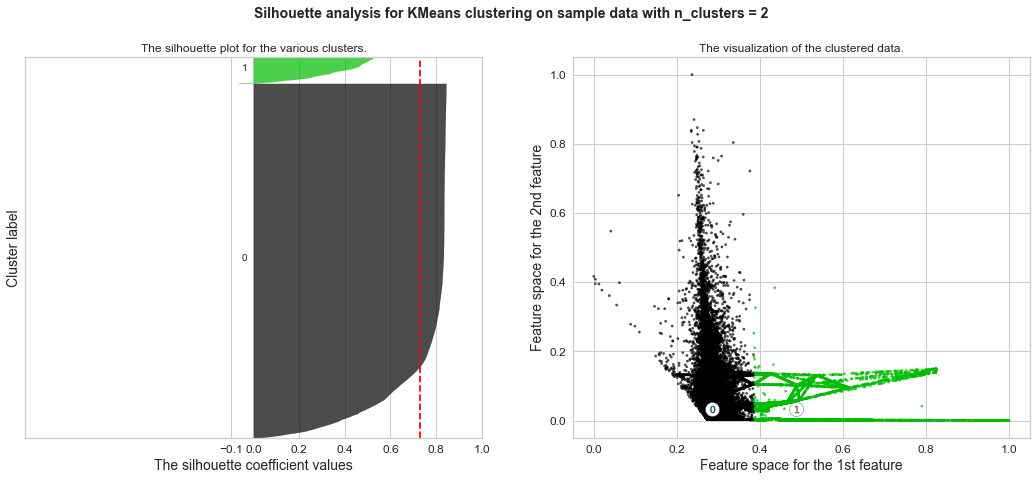

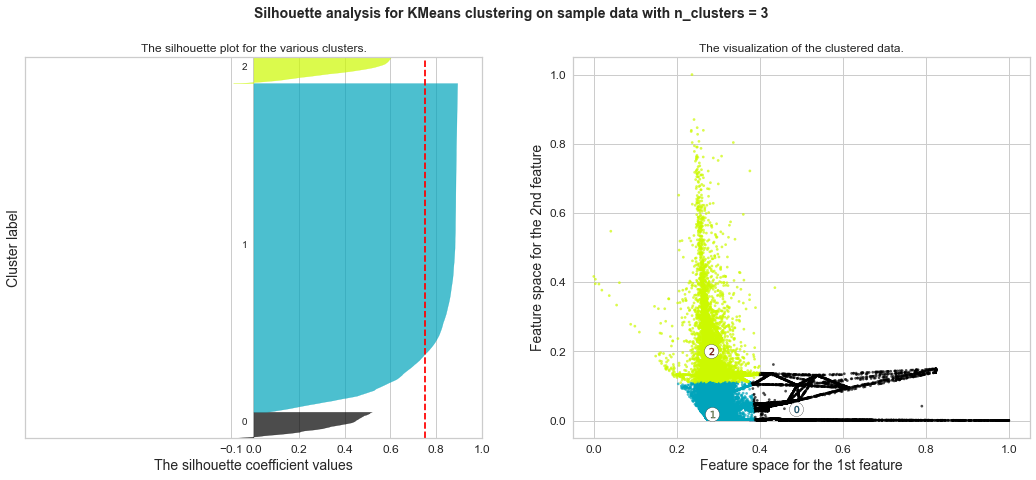

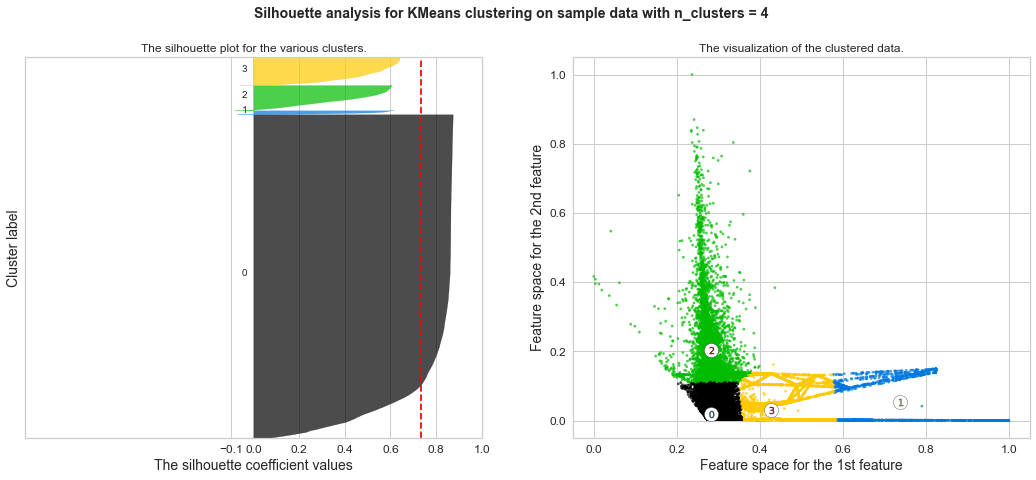

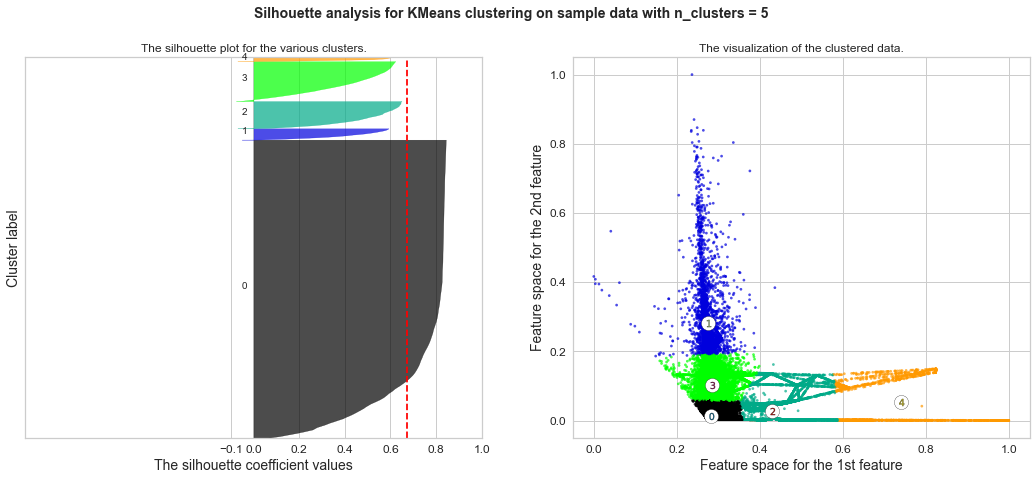

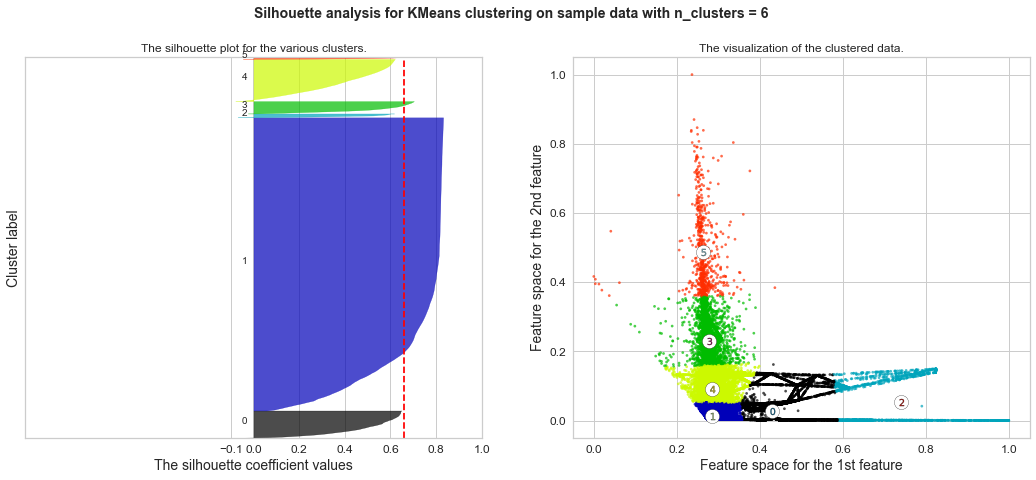

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    print('plotting for cluster: ', n_clusters)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init="k-means++",random_state=100)
    cluster_labels = clusterer.fit_predict(X)
    # calculating accuracy for n cluster
    score = metrics.accuracy_score(cluster_labels,y)
    print('Accuracy:{0:f}'.format(score))

    print('cluster labels : ', cluster_labels)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000)#metrics.silhouette_score(X,cluster_labels,metric="euclidean", random_state =100)
    
    print('silhouette_avg : ', silhouette_avg)

    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    print(X.shape)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

This confirms with Elbow best which was k=4

Checking sensitivity measure

In [48]:
# with help of elbow plot and silhouette figures, we see that our best k in our algorithm is 4

kmeans_iter1 = KMeans(n_clusters=3, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=3, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=3, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X.astype('float'))
kmeans_iter2.fit(X.astype('float'))
kmeans_iter3.fit(X.astype('float'))

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=3, n_init=1,
       random_state=1)

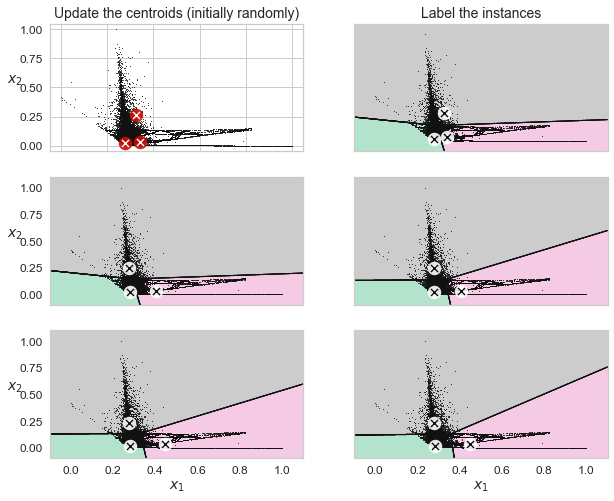

In [49]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

# Conclusion
Observing the two algorithms used Hard and Soft clustering, it seems that for this particular dataset it s doing well when centroids were defined .i.e hard clustering, kmeans seemed to be better at clustering the dataset than GM algorithm.

Using Elbow plot and Silhoute plot we observed that k=3 is the optimal comparing to other values, it produces high silhoute score which shows for k=3 data is better clustered.

I have also noticed that clustering is sensitive to the pposition of centroids, changing it will change decision boundaries.

Overall, vieing decision boundaries and the fact that given dataset is heavily densed, clustering is not good idea on finding possible classes for this particular dataset